In [1]:
import numpy as np
import os 
import pandas as pd
import cv2
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torch import nn
import torchsummary
from torch.utils.data import DataLoader
from collections import defaultdict
from torchvision.utils import make_grid
import matplotlib.image as mpimg
from collections import Counter

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
CLASS_NAME_TO_ID = {'Unformed': 0, 'Burr': 1}
CLASS_ID_TO_NAME = {0: 'Unformed', 1: 'Burr'}
BOX_COLOR = {'Unformed':(200, 0, 0), 'Burr':(0, 0, 200)}
TEXT_COLOR = (255, 255, 255)

def save_model(model_state, model_name, save_dir="./trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))


def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=2):
    x_center, y_center, w, h = bbox
    x_min = int(x_center - w/2)
    y_min = int(y_center - h/2)
    x_max = int(x_center + w/2)
    y_max = int(y_center + h/2)
    
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=color[class_name], thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(image, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color[class_name], -1)
    cv2.putText(
        image,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return image


def visualize(image, bboxes, category_ids):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
#         print('category_id: ',category_id)
        class_name = CLASS_ID_TO_NAME[category_id.item()]
        img = visualize_bbox(img, bbox, class_name)
    return img

In [4]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(image_list, dim=0), target_list, filename_list


In [5]:
class PET_dataset():
    def __init__(self,part,neck_dir,body_dir,phase, transformer=None, aug=None, aug_factor=0):
        self.neck_dir=neck_dir
        self.body_dir=body_dir
        self.part=part
        self.phase=phase
        self.transformer=transformer
        self.aug=aug
        self.aug_factor=aug_factor
        if(self.part=="body"):
            self.image_files = sorted([fn for fn in os.listdir(self.body_dir+"/"+self.phase+"/image") if fn.endswith("jpg")])
            self.label_files= sorted([lab for lab in os.listdir(self.body_dir+"/"+self.phase+"/label") if lab.endswith("txt")])
        elif(self.part=="neck"):
            self.image_files = sorted([fn for fn in os.listdir(self.neck_dir+"/"+self.phase+"/image") if fn.endswith("jpg")])
            self.label_files= sorted([lab for lab in os.listdir(self.neck_dir+"/"+self.phase+"/label") if lab.endswith("txt")])
        
        self.auged_img_list, self.auged_label_list=self.make_aug_list(self.image_files, self.label_files)
        
    def __getitem__(self,index):
        if(self.aug==None):
            filename, image = self.get_image(self.part, index)
            bboxes, class_ids = self.get_label(self.part, index)

            if(self.transformer):
                transformed_data=self.transformer(image=image, bboxes=bboxes, class_ids=class_ids)
                image = transformed_data['image']
                bboxes = np.array(transformed_data['bboxes'])
                class_ids = np.array(transformed_data['class_ids'])


            target = {}
    #         print(f'bboxes:{bboxes}\nclass_ids:{class_ids}\nlen_bboxes:{len(bboxes)}\nlen_class_ids:{len(class_ids)}')
    #         print(f'filename: {filename}')
            target["boxes"] = torch.Tensor(bboxes).float()
            target["labels"] = torch.Tensor(class_ids).long()

            ###
            bboxes=torch.Tensor(bboxes).float()
            class_ids=torch.Tensor(class_ids).long()
            target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
            ###
        else:
            image=self.auged_img_list[index][1]
            target=self.auged_label_list[index]
            filename=self.auged_img_list[index][0]
        return image, target, filename
    
    def __len__(self, ):
        length=0
        if(self.aug==None):
            length=len(self.image_files)
        else:
            length=len(self.auged_img_list)
        return length
    
    def make_aug_list(self,ori_image_list,ori_label_files):
        aug_image_list=[]
        aug_label_list=[]
        
        print(f"start making augmented images-- augmented factor:{self.aug_factor}")
        for i in range(len(ori_image_list)):
            filename, ori_image = self.get_image(self.part, i)
            ori_bboxes, ori_class_ids = self.get_label(self.part, i)
            for j in range(self.aug_factor):
                auged_data=self.aug(image=ori_image, bboxes=ori_bboxes, class_ids=ori_class_ids)
                image = auged_data['image']
                bboxes = np.array(auged_data['bboxes'])
                class_ids = np.array(auged_data['class_ids'])
                
                bboxes=torch.Tensor(bboxes).float()
                class_ids=torch.Tensor(class_ids).long()
                
                aug_image_list.append((filename, image))
                aug_label_list.append(np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1))
        
        print(f"total length of augmented images: {len(aug_image_list)}")
        
        return aug_image_list, aug_label_list
        
    
    def get_image(self, part, index): # 이미지 불러오는 함수
        filename = self.image_files[index]
        if(part=="body"):
#             print(f"body called!-> {self.part}")
            image_path = self.body_dir+"/"+self.phase+"/image/"+filename
        elif(part=="neck"):
#             print(f"neck called!-> {self.part}")
            image_path = self.neck_dir+"/"+self.phase+"/image/"+filename
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
    
    def get_label(self, part, index): # label (box좌표, class_id) 불러오는 함수
        label_filename=self.label_files[index]
        if(part=="body"):
#             print(f"body label called!-> {self.part}")
            label_path = self.body_dir+"/"+self.phase+"/label/"+label_filename
        elif(part=="neck"):
#             print(f"neck label called!-> {self.part}")
            label_path = self.neck_dir+"/"+self.phase+"/label/"+label_filename
        with open(label_path, 'r') as file:
            labels = file.readlines()
        
        class_ids=[]
        bboxes=[]
        for label in labels:
            label=label.replace("\n", "")
            obj=label.split(' ')[0]
            coor=label.split(' ')[1:]
            obj=int(obj)
            coor=list(map(float, coor))
            class_ids.append(obj)
            bboxes.append(coor)
            
        return bboxes, class_ids
    

# YOLO-CBAM

In [6]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init
# from .cbam import *
# from .bam import *

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        self.final_conv = nn.Conv2d(512, 12, kernel_size=1, stride=1, padding=0, bias=False)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

#         if self.network_type == "ImageNet":
#             x = self.avgpool(x)
#         else:
        x = F.avg_pool2d(x, 2)
        x = self.final_conv(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
        return x

def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

## YOLO-ResNet

In [9]:
class YOLO_RESNET18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.num_bboxes = 2
        self.grid_size = 7

        resnet18 = torchvision.models.resnet18(pretrained = True)
#         swin=torchvision.models.swin_v2_t(weights='IMAGENET1K_V1')
        layers = [m for m in resnet18.children()] #Resnet에서 Yolo에서 가져올수 있을만한 layer만 선별적으로 가져오기 위해서

        # 기존 Resnet18의 layer들중에서 맨 뒤에 두개만 제외하고 다 가져와서 Backbone으로 사용
        self.backbone = nn.Sequential(*layers[:-2]) 
        self.head = nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=1024, out_channels=(4+1)*self.num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),
                nn.AdaptiveAvgPool2d(output_size=(self.grid_size, self.grid_size))
            )

    def forward(self, x):
        out = self.backbone(x)
        # out = self.neck(out)
        out = self.head(out) # input (batch, 3, 448, 448) -> output feature (batch, 12, 7, 7)
        return out


## YOLO-Swin

In [6]:
class YOLO_SWIN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.num_bboxes = 2
        self.grid_size = 7

#         resnet18 = torchvision.models.resnet18(pretrained = True)
        swin=torchvision.models.swin_v2_t(weights='IMAGENET1K_V1')
        layers = [m for m in swin.children()] #Resnet에서 Yolo에서 가져올수 있을만한 layer만 선별적으로 가져오기 위해서

        # 기존 Resnet18의 layer들중에서 맨 뒤에 두개만 제외하고 다 가져와서 Backbone으로 사용
        self.backbone = nn.Sequential(*layers[:-3]) 
        self.head = nn.Sequential(
                nn.Conv2d(in_channels=768, out_channels=1024, kernel_size=1, padding=0,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1,bias=False),
                nn.BatchNorm2d(1024),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=1024, out_channels=(4+1)*self.num_bboxes+num_classes, kernel_size=1, padding=0, bias=False),
                nn.AdaptiveAvgPool2d(output_size=(self.grid_size, self.grid_size))
            )

    def forward(self, x):
        out = self.backbone(x)
        # out = self.neck(out)
        out = self.head(out) # input (batch, 3, 448, 448) -> output feature (batch, 12, 7, 7)
        return out


In [8]:
NUM_CLASSES = 2
# model = YOLO_SWIN(num_classes=NUM_CLASSES)
model = ResNet(BasicBlock, [3, 4, 6, 3], network_type="ImageNet", num_classes=NUM_CLASSES, att_type="CBAM")
model.to(device)

/tmp/ipykernel_3978/1777674582.py:131: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
/tmp/ipykernel_3978/1777674582.py:135: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias=True)
          

In [9]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
#     model = YOLO_SWIN(num_classes=num_classes)
#     model = YOLO_SWIN(num_classes=num_classes)
    model = ResNet(BasicBlock, [3, 4, 6, 3], network_type="ImageNet", num_classes=NUM_CLASSES, att_type="CBAM")
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [10]:
IMAGE_SIZE=448
transformer = A.Compose([
            A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
)

## 학습된 모델 가져오기

In [11]:
# ckpt_path="./trained_model/YOLO_SWIN_T_body_LR0.0001_AUG30/model_90.pth"
ckpt_path="/workspace/Plastic_Bottle_defect_detection/trained_model/YOLO_RESNET_CBAM_neck_LR0.0001_IP50_nonPretrain/model_100.pth"
model = load_model(ckpt_path, NUM_CLASSES, device)
model_name=ckpt_path.split("/workspace/Plastic_Bottle_defect_detection/trained_model/")[1].split("/model")[0]
model_name

/tmp/ipykernel_3978/1777674582.py:131: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
/tmp/ipykernel_3978/1777674582.py:135: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


'YOLO_RESNET_CBAM_neck_LR0.0001_IP50_nonPretrain'

## Test dataset가져오기

In [12]:
NECK_PATH = '/home/host_data/PET_data/Neck'
BODY_PATH = '/home/host_data/PET_data/Body'
test_dataset=PET_dataset("neck" ,neck_dir=NECK_PATH,body_dir=BODY_PATH,phase='test', transformer=transformer, aug=None)
test_dataloaders = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

start making augmented images-- augmented factor:0
total length of augmented images: 0


In [13]:
@torch.no_grad()
def model_predict(image, model, conf_thres=0.2, iou_threshold=0.1):
    predictions = model(image)
    prediction = predictions.detach().cpu().squeeze(dim=0)
#     print(prediction.shape)
    
    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    stride_size = IMAGE_SIZE/grid_size

    conf = prediction[[0,5], ...].reshape(1, -1)
    xc = (prediction[[1,6], ...] * IMAGE_SIZE + x_grid*stride_size).reshape(1,-1)
    yc = (prediction[[2,7], ...] * IMAGE_SIZE + y_grid*stride_size).reshape(1,-1)
    w = (prediction[[3,8], ...] * IMAGE_SIZE).reshape(1,-1)
    h = (prediction[[4,9], ...] * IMAGE_SIZE).reshape(1,-1)
    cls = torch.max(prediction[10:, ...].reshape(NUM_CLASSES, -1), dim=0).indices.tile(1,2)
    
    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0,1)

    # x_min과 y_min이 음수가 되지않고, x_max와 y_max가 이미지 크기를 넘지 않게 제한
    prediction_res[:, 2].clip(min=0, max=image.shape[1]) 
    prediction_res[:, 3].clip(min=0, max=image.shape[0])
        
    pred_res = prediction_res[prediction_res[:, 4] > conf_thres]
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()
    
    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    scores = pred_res_[:, 4]
    class_ids = pred_res_[:, 5]
    
    # 이미지 값이 들어가면 모델을 통해서, 후처리까지 포함된 yolo 포멧의 box좌표, 그 좌표에 대한 confidence score
    # 그리고 class id를 반환
    return bboxes, scores, class_ids

In [14]:
def convertToAbsoluteValues(size, box):
    
#     xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
#     yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
#     xEnd = xIn + round(float(box[2]) * size[0])
#     yEnd = yIn + round(float(box[3]) * size[1])
    xIn = round(((2 * float(box[0]) - float(box[2])) / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) / 2))
    xEnd = xIn + round(float(box[2]))
    yEnd = yIn + round(float(box[3]))
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
        
    return (xIn/size[0], yIn/size[1], xEnd/size[0], yEnd/size[1])
#     return (xIn, yIn, xEnd, yEnd)

## Detection한 결과 폴더로 만들어주기(VOC type)

In [15]:
# detection 만들기
pred_images = []
pred_labels =[]

for index, batch in enumerate(test_dataloaders):
    images = batch[0].to(device)
    filename=batch[2]
    print(images.shape)
    
    bboxes, scores, class_ids = model_predict(images, model, conf_thres=0.1, iou_threshold=0.1)
    
    if len(bboxes) > 0:
        prediction_yolo = np.concatenate([bboxes, scores[:, np.newaxis], class_ids[:, np.newaxis]], axis=1)
    else:
        prediction_yolo = np.array([])
    
    # 텐서형의 이미지를 다시 unnormalize를 시키고, 다시 chw를 hwc로 바꾸고 넘파이로 바꾼다.
    np_image = make_grid(images[0], normalize=True).cpu().permute(1,2,0).numpy()
    pred_images.append(np_image)
    pred_labels.append(prediction_yolo)
    print(f"filename:{filename}, prediction_yolo:{prediction_yolo}\n")
#     print(f"{convertToAbsoluteValues(size=(images.shape[2],images.shape[3]),box=prediction_yolo[0][0:4])}")
    txt_name=filename[0].split(".")[0]+".txt"
    os.makedirs(f"/home/host_data/PET_data_for_measure/Neck/test/label/detection/{model_name}", exist_ok=True)
    f = open(f"/home/host_data/PET_data_for_measure/Neck/test/label/detection/{model_name}/"+txt_name, 'w')
    for i in range(len(prediction_yolo)):
        print(f"box={prediction_yolo[i][0:4]}")
        c=convertToAbsoluteValues(size=(images.shape[2],images.shape[3]),box=prediction_yolo[i][0:4])
        print(f"size={(images.shape[2],images.shape[3])}, c--{c}")
        text=f"{int(prediction_yolo[i][5])} {prediction_yolo[i][4]} {c[0]} {c[1]} {c[2]} {c[3]}\n"
        f.write(text)

    

torch.Size([1, 3, 448, 448])
filename:['shape1_121.jpg'], prediction_yolo:[[4.0392667e+02 2.2255539e+02 3.4422546e+01 1.5781598e+02 1.6301501e-01
  0.0000000e+00]
 [4.3959952e+02 2.0051102e+02 5.5452393e+01 1.9021477e+02 1.1502689e-01
  0.0000000e+00]]

box=[403.92667  222.55539   34.422546 157.81598 ]
size=(448, 448), c--(0.8638392857142857, 0.32142857142857145, 0.9397321428571429, 0.6741071428571429)
box=[439.59952  200.51102   55.452393 190.21477 ]
size=(448, 448), c--(0.9196428571428571, 0.234375, 0.9977678571428571, 0.6584821428571429)
torch.Size([1, 3, 448, 448])
filename:['shape1_148.jpg'], prediction_yolo:[[2.93882935e+02 9.34684448e+01 1.08112686e+02 9.63422546e+01
  1.28051937e-01 0.00000000e+00]
 [4.31984650e+02 1.85546768e+02 6.94427490e+01 1.04503876e+02
  1.12799764e-01 0.00000000e+00]
 [6.99112091e+01 3.32175476e+02 4.18239746e+01 1.29023132e+02
  1.05360717e-01 0.00000000e+00]]

box=[293.88293   93.468445 108.112686  96.342255]
size=(448, 448), c--(0.5357142857142857, 0

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3423.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3, 448, 448])
filename:['shape1_80.jpg'], prediction_yolo:[[3.8538794e+02 1.4061327e+02 1.0417395e+02 9.0500221e+01 1.4625108e-01
  0.0000000e+00]]

box=[385.38794 140.61327 104.17395  90.50022]
size=(448, 448), c--(0.7433035714285714, 0.21205357142857142, 0.9754464285714286, 0.41517857142857145)
torch.Size([1, 3, 448, 448])
filename:['shape1_99.jpg'], prediction_yolo:[[4.3428763e+02 2.8371945e+02 3.8426208e+01 8.1954224e+01 1.1257082e-01
  0.0000000e+00]]

box=[434.28763 283.71945  38.42621  81.95422]
size=(448, 448), c--(0.9263392857142857, 0.5424107142857143, 0.9977678571428571, 0.7254464285714286)
torch.Size([1, 3, 448, 448])
filename:['shape2_105.jpg'], prediction_yolo:[[2.5018716e+02 1.4130373e+02 5.1940186e+01 1.4308377e+02 1.4708322e-01
  0.0000000e+00]
 [4.2297650e+02 1.6131885e+02 3.8424255e+01 1.6021756e+02 1.4296103e-01
  0.0000000e+00]]

box=[250.18716  141.30373   51.940186 143.08377 ]
size=(448, 448), c--(0.5, 0.15625, 0.6160714285714286, 0.475446428571428

## Detection한 결과 Plot

In [16]:

from ipywidgets import interact

@interact(index=(0,len(pred_images)-1))
def show_result(index=0):
    print(pred_labels[index])
    if len(pred_labels[index]) > 0:
        result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 5])
    else:
        result = pred_images[index]
        
    plt.figure(figsize=(6,6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=24), Output()), _dom_classes=('widget-intera…

In [17]:
def convertToAbsoluteValues_size(size, box):
    
#     xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
#     yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
#     xEnd = xIn + round(float(box[2]) * size[0])
#     yEnd = yIn + round(float(box[3]) * size[1])
    xIn = (2 * float(box[0]) - float(box[2])) / 2
    yIn = (2 * float(box[1]) - float(box[3])) / 2
    xEnd = xIn + float(box[2])
    yEnd = yIn + float(box[3])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
        
    return (xIn, yIn, xEnd, yEnd)

## Annotation을 폴더로 만들어주기(VOC type)

## 탐지성능검증을 위한 지표 적용

In [18]:
# 0: 'Unformed', 1: 'Burr'
num2class = {"0.0" : "Unformed", "1.0" : "Burr"}

In [19]:
# box : (centerX, centerY, width, height)
def convertToAbsoluteValues(size, box):
    
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

# def convertToRelativeValues(size, box):
#     dw = 1. / (size[0])
#     dh = 1. / (size[1])
#     cx = (box[1] + box[0]) / 2.0
#     cy = (box[3] + box[2]) / 2.0
#     w = box[1] - box[0]
#     h = box[3] - box[2]
#     x = cx * dw
#     y = cy * dh
#     w = w * dw
#     h = h * dh
#     # x,y => (bounding_box_center)/width_of_the_image
#     # w => bounding_box_width / width_of_the_image
#     # h => bounding_box_height / height_of_the_image
#     return (x, y, w, h)

In [20]:
def boundingBoxes(labelPath, imagePath, model_name):
    
    detections, groundtruths, classes = [], [], []
    
    for boxtype in os.listdir(labelPath):
        
        if boxtype=="detection":
            boxtypeDir=labelPath+boxtype+"/"+model_name+"/"
        else:
            boxtypeDir = os.path.join(labelPath,boxtype)

        for labelfile in os.listdir(boxtypeDir):
            if labelfile ==".ipynb_checkpoints":
                continue
            filename = os.path.splitext(labelfile)[0]
            with open(os.path.join(boxtypeDir, labelfile)) as f:
                labelinfos = f.readlines()

            imgfilepath = os.path.join(imagePath, filename + ".jpg")
            print(imgfilepath )
            img = cv2.imread(imgfilepath)
            print(img.shape)
            h, w, _ = img.shape

            for labelinfo in labelinfos:
                label, conf, rx1, ry1, rx2, ry2 = map(float, labelinfo.strip().split())
#                 x1, y1, x2, y2 = convertToAbsoluteValues((448, 448), (rx1, ry1, rx2, ry2))
#                 boxinfo = [filename, label, conf, (x1, y1, x2, y2)]
                boxinfo = [filename, label, conf, (rx1*448, ry1*448, rx2*448, ry2*448)]
                
                if label not in classes:
                    classes.append(label)
                
                if boxtype == "detection":
                    detections.append(boxinfo)
                else:
                    groundtruths.append(boxinfo)
                    
    classes = sorted(classes)
                
    return detections, groundtruths, classes

detections, groundtruths, classes = boundingBoxes(f"/home/host_data/PET_data_for_measure/Neck/test/label/", "/home/host_data/PET_data_for_measure/Neck/test/image/",model_name)
print(f"detections:{detections}\n\n")
print(f"groundtruths:{groundtruths}\n\n")
print(f"classes:{classes}\n\n")

/home/host_data/PET_data_for_measure/Neck/test/image/shape1_48.jpg
(296, 1209, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_151.jpg
(265, 1235, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_81.jpg
(289, 1233, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_75.jpg
(253, 1230, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_127.jpg
(290, 1236, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_53.jpg
(267, 1222, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_79.jpg
(258, 1230, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_55.jpg
(251, 1225, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape1_148.jpg
(303, 1231, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape2_14.jpg
(268, 1233, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape1_121.jpg
(310, 1238, 3)
/home/host_data/PET_data_for_measure/Neck/test/image/shape3_15.jpg
(232, 1241, 3)
/home/host_d

In [21]:
transformer = A.Compose([ 
        # bounding box의 변환, augmentation에서 albumentations는 Detection 학습을 할 때 굉장히 유용하다. 
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
#         A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
        # albumentations 라이브러리에서는 Normalization을 먼저 진행해 주고 tensor화를 진행해 주어야한다.
    ]
    
)

## Prediction & Annotation 비교이미지 저장

(448, 448, 3)
shape1_121
[(387.0, 144.0, 421.0, 302.0, 0.16301500797271729), (412.0, 105.0, 447.0, 295.0, 0.11502689123153687), (51.74780488014221, 273.13552379608154, 76.71708464622498, 338.16765308380127, 1.0)]


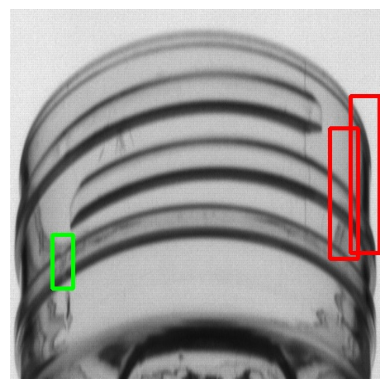

(448, 448, 3)
shape1_148
[(240.0, 45.0, 348.0, 141.0, 0.12805193662643433), (397.0, 133.0, 447.0, 238.0, 0.1127997636795044), (49.0, 268.0, 91.0, 397.0, 0.1053607165813446), (223.09011936187744, 53.22777700424194, 296.6042318344116, 143.4191403388977, 1.0)]


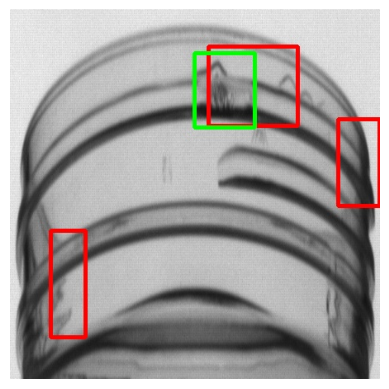

(448, 448, 3)
shape1_153
[(381.0, 142.0, 425.0, 283.0, 0.17630398273468018), (416.0, 69.0, 447.0, 233.0, 0.16890060901641846), (317.0, 66.0, 417.0, 170.0, 0.12390261888504028), (62.03635311126709, 105.86307716369629, 134.47436618804932, 182.57546043395996, 1.0), (215.82735633850098, 223.99998998641968, 239.2304286956787, 289.9724678993225, 1.0)]


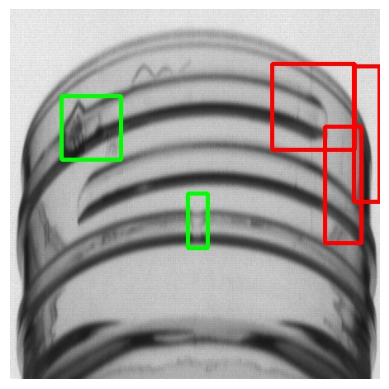

(448, 448, 3)
shape1_48
[(108.0, 55.0, 204.0, 134.0, 0.12703192234039307), (333.0, 158.0, 398.0, 254.0, 0.10362780094146729), (395.01077902317047, 295.1352262496948, 413.1677716970444, 352.6485719680786, 1.0)]


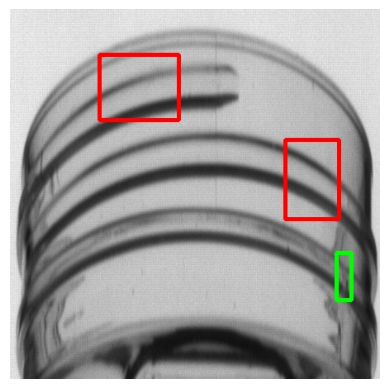

(448, 448, 3)
shape1_65
[(184.0, 52.0, 275.0, 162.0, 0.16312003135681152), (384.0, 129.0, 445.0, 205.0, 0.12055361270904541), (263.0, 68.0, 356.0, 153.0, 0.11938858032226562), (197.6360855102539, 51.286367416381836, 258.8445358276367, 152.3502426147461, 1.0), (146.75202786922455, 238.32995748519897, 167.40079653263092, 294.141348361969, 1.0)]


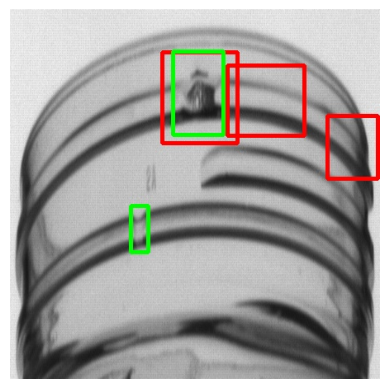

(448, 448, 3)
shape1_80
[(333.0, 95.0, 437.0, 186.0, 0.14625108242034912), (13.306719779968262, 123.63634777069092, 84.64669036865234, 247.27270221710205, 1.0), (365.57114827632904, 258.9088280200958, 384.7921406030655, 314.1817252635956, 1.0)]


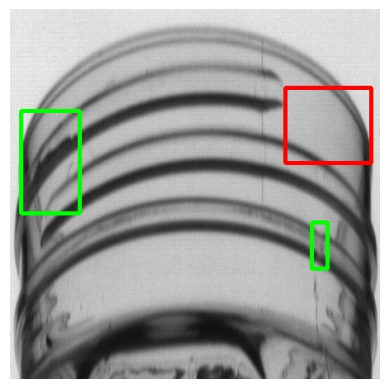

(448, 448, 3)
shape1_99
[(415.0, 243.0, 447.0, 325.0, 0.11257082223892212), (216.64361000061035, 229.42573499679565, 240.91938591003418, 303.83405351638794, 1.0)]


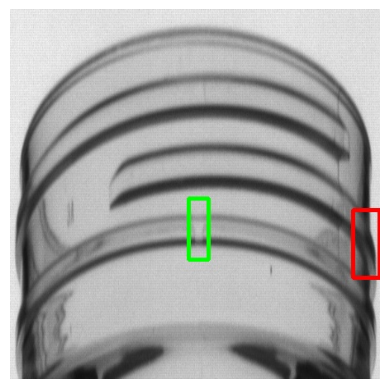

(448, 448, 3)
shape2_105
[(224.0, 70.0, 276.0, 213.0, 0.14708322286605835), (404.0, 81.0, 442.0, 241.0, 0.1429610252380371), (235.8471486568451, 108.13779211044312, 258.8120768070221, 197.3946213722229, 1.0)]


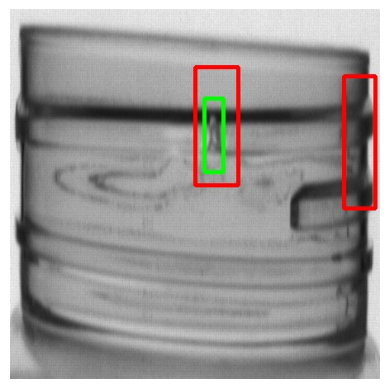

(448, 448, 3)
shape2_127
[(92.80012965202332, 133.33352899551392, 121.5813057422638, 214.43541860580444, 1.0)]


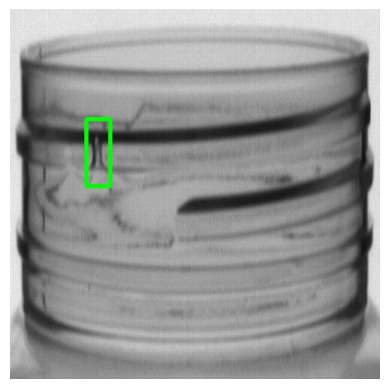

(448, 448, 3)
shape2_135
[(258.0, 73.0, 296.0, 314.0, 0.12354886531829834), (924.0, 720.0, 447.0, 447.0, 0.1102467030286789), (289.1969887018204, 61.01805877685547, 303.0375007390976, 324.3587188720703, 1.0)]


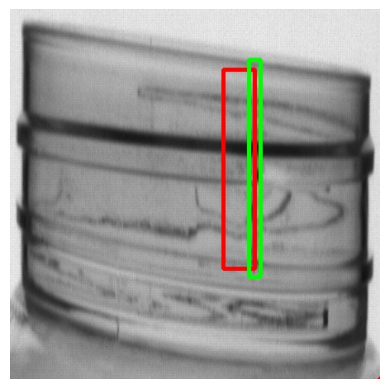

(448, 448, 3)
shape2_14
[(357.0, 97.0, 378.0, 216.0, 0.27099335193634033), (41.77418541908264, 23.397024154663086, 57.93807005882263, 279.3613872528076, 1.0), (334.19540095329285, 121.22230386734009, 356.8786270618439, 209.3040328025818, 1.0)]


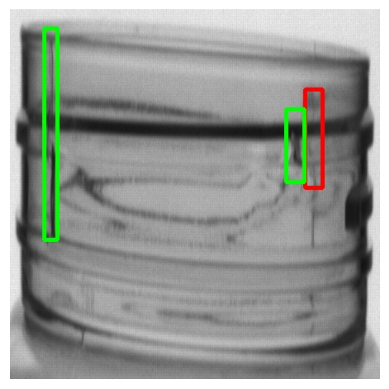

(448, 448, 3)
shape2_151
[(162.0, 107.0, 202.0, 213.0, 0.2106645107269287), (320.0, 60.0, 377.0, 226.0, 0.1203661561012268), (137.4835822582245, 113.26805973052979, 170.4940140247345, 199.4870023727417, 1.0)]


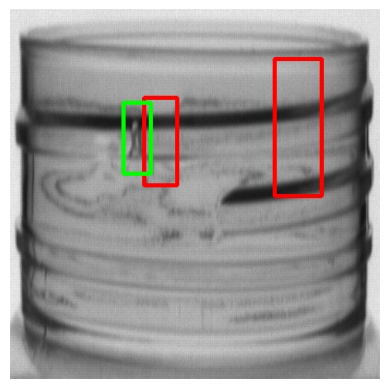

(448, 448, 3)
shape2_53
[(198.0, 137.0, 236.99999999999997, 305.0, 0.1509820520877838), (49.07739496231079, 83.40371799468994, 69.08350706100464, 166.0955572128296, 1.0)]


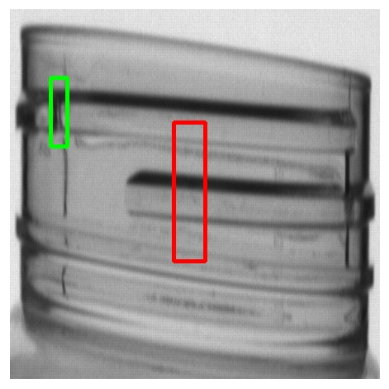

(448, 448, 3)
shape2_55
[(153.0, 73.0, 154.0, 183.0, 0.1883835792541504), (404.0, 80.0, 434.0, 263.0, 0.10596632957458496), (151.40562987327576, 92.8126049041748, 183.22258973121643, 192.764986038208, 1.0)]


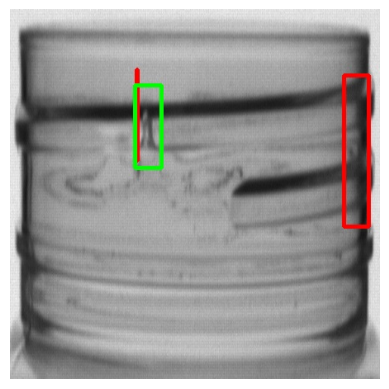

(448, 448, 3)
shape2_70
[(421.0, 80.0, 444.0, 239.00000000000003, 0.1365644335746765), (197.0, 125.0, 225.00000000000003, 306.0, 0.10375335812568665), (42.87348794937134, 83.60934352874756, 61.196911334991455, 161.5918092727661, 1.0)]


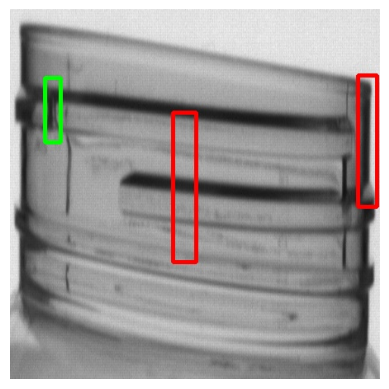

(448, 448, 3)
shape2_75
[(73.0, 55.0, 110.0, 197.0, 0.11948412656784058), (415.0, 87.0, 438.0, 261.0, 0.11042642593383789), (96.52003455162048, 108.01594352722168, 121.28771424293518, 194.78278923034668, 1.0)]


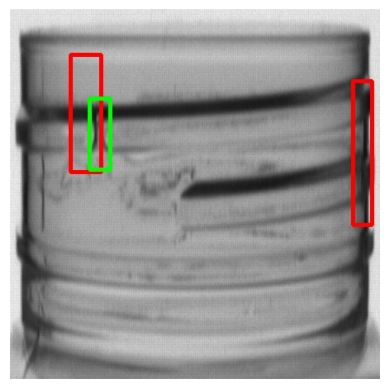

(448, 448, 3)
shape2_79
[(139.0, 75.0, 168.0, 193.0, 0.21633964776992798), (149.33318424224854, 102.44953775405884, 176.6504316329956, 208.3719687461853, 1.0)]


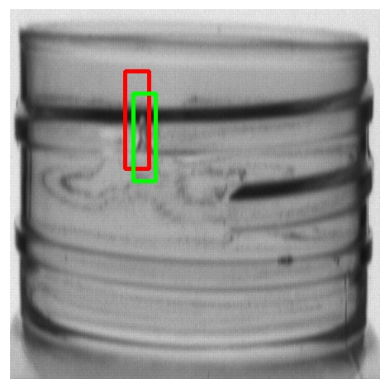

(448, 448, 3)
shape2_81
[(276.0, 117.0, 334.0, 208.0, 0.2831760346889496), (394.0, 114.99999999999999, 446.0, 277.0, 0.14919239282608032), (284.0, 385.0, 414.0, 442.0, 0.1049317717552185), (271.0527641773224, 130.21433210372925, 305.20694041252136, 218.57426500320435, 1.0)]


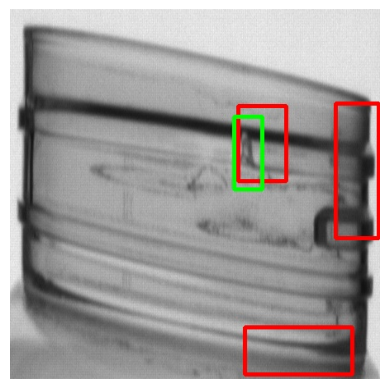

(448, 448, 3)
shape3_12
[(377.0, 129.0, 411.0, 292.0, 0.1096491813659668), (131.0, 304.0, 195.0, 424.0, 0.10230076313018799), (90.54909014701843, 137.6970500946045, 123.04477047920227, 236.60604286193848, 1.0)]


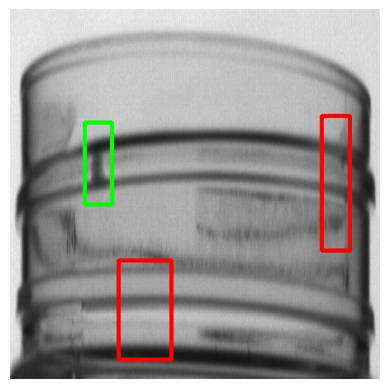

(448, 448, 3)
shape3_14
[(214.7048840522766, 148.05145931243896, 251.88619565963745, 228.80704593658447, 1.0)]


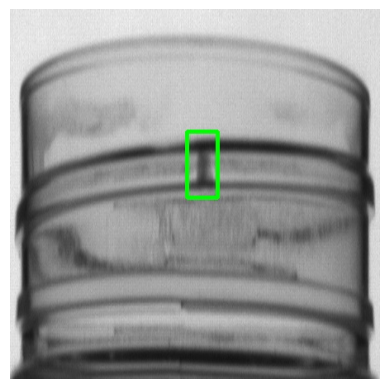

(448, 448, 3)
shape3_15
[(364.0, 144.0, 404.0, 260.0, 0.12990295886993408), (72.71380376815796, 150.98294496536255, 97.81470537185669, 246.10096311569214, 1.0)]


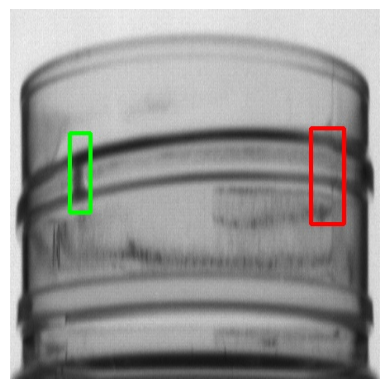

(448, 448, 3)
shape3_44
[(327.0, 112.0, 372.0, 190.0, 0.10171324014663696), (363.7482293844223, 106.66678047180176, 383.52922117710114, 209.45455360412598, 1.0)]


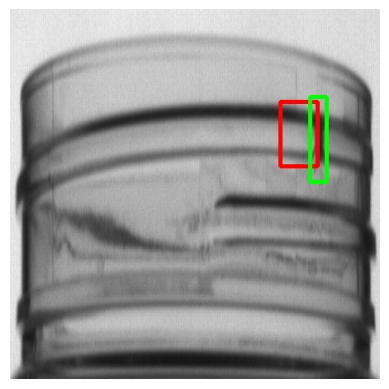

(448, 448, 3)
shape4_24
[(6.0, 125.0, 57.0, 210.0, 0.20376920700073242), (404.0, 107.0, 440.0, 204.0, 0.1728532910346985), (2.0, 222.0, 49.0, 297.0, 0.10964769124984741), (328.0, 369.0, 346.0, 439.0, 0.10690367221832275), (85.0, 240.0, 159.0, 316.0, 0.10219568014144897), (58.89004611968994, 118.36362028121948, 85.4994535446167, 181.99978303909302, 1.0)]


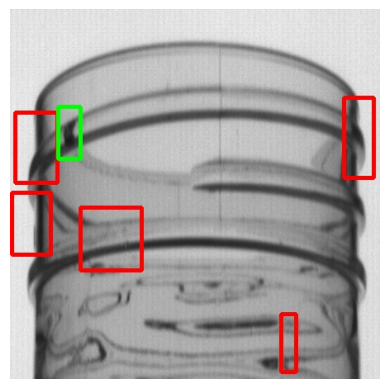

(448, 448, 3)
shape5_34
[(287.6713237762451, 204.56621408462524, 322.95894050598145, 247.5249342918396, 1.0)]


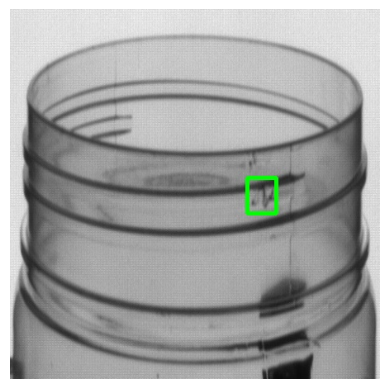

(448, 448, 3)
shape6_34
[(112.38998222351074, 155.76624202728271, 130.7315502166748, 216.4187250137329, 1.0)]


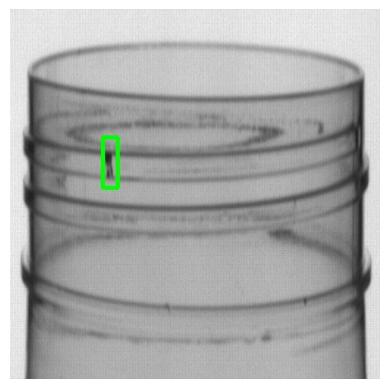

In [22]:
def boxPlot(boxlist, imagePath, savePath):
    labelfiles = sorted(list(set([filename for filename, _, _, _ in boxlist])))
    
    for labelfile in labelfiles:
    
        rectinfos = []
        imgfilePath = os.path.join(imagePath, labelfile + ".jpg")
        img = cv2.imread(imgfilePath)
        img_t=transformer(image=img)
        img=img_t['image'].permute(1,2,0).numpy()
        print(img.shape)

        for filename, _, conf, (x1, y1, x2, y2) in boxlist:
            if labelfile == filename:
                rectinfos.append((x1, y1, x2, y2, conf))
        print(labelfile)
        print(rectinfos)
        for x1, y1, x2, y2, conf in rectinfos:
            
            if conf == 1.0:
                rectcolor = (0, 255, 0)
            else:
                rectcolor = (0, 0, 255)
                
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), rectcolor, 4)
        os.makedirs(savePath, exist_ok=True)
        cv2.imwrite(f"{savePath}/{labelfile}.jpg", img)

        img = mpimg.imread(f"{savePath}/{labelfile}.jpg")
        plt.axis("off")
        plt.imshow(img)
        plt.show()
        
# boxPlot(detections, "image", savePath="boxed_images/detection")
# boxPlot(groundtruths, "image", savePath="boxed_images/groundtruth")
boxPlot(detections + groundtruths, "/home/host_data/PET_data_for_measure/Neck/test/image/", savePath=f"/workspace/Plastic_Bottle_defect_detection/results/boxed_images/{model_name}")

## IoU(Intersection over Union)

In [23]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
        
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

# boxA = (Ax1,Ay1,Ax2,Ay2)
# boxB = (Bx1,By1,Bx2,By2)
def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    # if boxes dont intersect
    if boxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    
    # intersection over union
    result = interArea / union
    assert result >= 0
    return result

In [24]:
boxA = detections[-1][-1]
boxB = groundtruths[-1][-1]

print(f"boxA coordinates : {(boxA)}")
print(f"boxA area : {getArea(boxA)}")
print(f"boxB coordinates : {(boxB)}")
print(f"boxB area : {getArea(boxB)}")

print(f"Union area of boxA and boxB : {getUnionAreas(boxA, boxB)}")

print(f"Does boxes Intersect? : {boxesIntersect(boxA, boxB)}")

print(f"Intersection area of boxA and boxB : {getIntersectionArea(boxA, boxB)}")

print(f"IoU of boxA and boxB : {iou(boxA, boxB)}")

boxA coordinates : (415.0, 243.0, 447.0, 325.0)
boxA area : 2739.0
boxB coordinates : (216.64361000061035, 229.42573499679565, 240.91938591003418, 303.83405351638794)
boxB area : 1906.0037606076694
Union area of boxA and boxB : 15347.279714895903
Does boxes Intersect? : False
Intersection area of boxA and boxB : -10702.275954288234
IoU of boxA and boxB : 0


## AP(Average Precision)

In [25]:
def calculateAveragePrecision(rec, prec):
    
    mrec = [0] + [e for e in rec] + [1]
    mpre = [0] + [e for e in prec] + [0]

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []

    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)

    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i-1]) * mpre[i])
    
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]

In [26]:
def ElevenPointInterpolatedAP(rec, prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp, recallValid = [], []

    for r in recallValues:
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0

        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])

        recallValid.append(r)
        rhoInterp.append(pmax)

    ap = sum(rhoInterp) / 11

    return [ap, rhoInterp, recallValues, None]

In [30]:
def AP(detections, groundtruths, classes, IOUThreshold = 0.3, method = 'AP'):
    
    result = []
    
    for c in classes:

        dects = [d for d in detections if d[1] == c]
        gts = [g for g in groundtruths if g[1] == c]

        npos = len(gts)

        dects = sorted(dects, key = lambda conf : conf[2], reverse=True)

        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))

        det = Counter(cc[0] for cc in gts)

        # 각 이미지별 ground truth box의 수
        # {99 : 2, 380 : 4, ....}
        # {99 : [0, 0], 380 : [0, 0, 0, 0], ...}
        for key, val in det.items():
            det[key] = np.zeros(val)


        for d in range(len(dects)):


            gt = [gt for gt in gts if gt[0] == dects[d][0]]

            iouMax = 0

            for j in range(len(gt)):
                iou1 = iou(dects[d][3], gt[j][3])
                if iou1 > iouMax:
                    iouMax = iou1
                    jmax = j

            if iouMax >= IOUThreshold:
                if det[dects[d][0]][jmax] == 0:
                    TP[d] = 1
                    det[dects[d][0]][jmax] = 1
                else:
                    FP[d] = 1
            else:
                FP[d] = 1

        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))

        if method == "AP":
            [ap, mpre, mrec, ii] = calculateAveragePrecision(rec, prec)
        else:
            [ap, mpre, mrec, _] = ElevenPointInterpolatedAP(rec, prec)

        r = {
            'class' : c,
            'precision' : prec,
            'recall' : rec,
            'AP' : ap,
            'interpolated precision' : mpre,
            'interpolated recall' : mrec,
            'total positives' : npos,
            'total TP' : np.sum(TP),
            'total FP' : np.sum(FP)
        }

        result.append(r)

    return result

result = AP(detections, groundtruths, classes,IOUThreshold=0.5)
print(result)

[{'class': 0.0, 'precision': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1       ,
       0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
       0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
       0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
       0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
       0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
       0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ]), 'recall': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.

## mAP(mean Average Precision)

In [31]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [32]:
for r in result:
    print("{:^8} AP : {}".format(num2class[str(r['class'])], r['AP']))
print("---------------------------")
print(f"mAP : {mAP(result)}")

Unformed AP : 0.003703703703703704
  Burr   AP : 0.0
---------------------------
mAP : 0.001851851851851852


## Prediction & Annotation 비교 plot

In [33]:
from ipywidgets import interact
both_path=f"/workspace/Plastic_Bottle_defect_detection/results/boxed_images/{model_name}/"
both_images=os.listdir(both_path)
@interact(index=(0,len(both_images)-1))
def show_result(index=0):
    box_img=cv2.imread(both_path+both_images[index])
    result = pred_images[index]
    print(both_images[index])
        
    plt.figure(figsize=(6,6))
    plt.imshow(box_img)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=24), Output()), _dom_classes=('widget-intera…